In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

2025-04-29 13:30:12.954484: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 13:30:12.999438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745951413.036218   43933 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745951413.046403   43933 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745951413.088301   43933 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# ===========================================
# 1. Imports and Configuration
# ===========================================
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
import scanpy as sc
import os

# Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.random.set_seed(42)
np.random.seed(42)

# Load data
adata = sc.read_h5ad('/home/frankfurt/LDL/data/abc_atlas/Zhuang-ABCA-1-merged-final-CLEAN-v2.h5ad')
print("Columns in adata.obs:", adata.obs.columns.tolist())

Columns in adata.obs: ['brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'parcellation_index']


In [3]:
# Show original dimensions
print(f"Original adata shape: {adata.shape}")  # (cells, genes)

Original adata shape: (2846908, 1122)


In [4]:
# ===========================================
# 2. Data Preprocessing
# ===========================================
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVG selection
# sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
# adata = adata[:, adata.var['highly_variable']].copy()

# # Subsample

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
adata = adata[:20000].copy()

# 2. Subset adata to keep only those genes
#adata = adata[:, adata.var['highly_variable']].copy()
# Show new dimensions
print(f"After HVG filtering: {adata.shape}")  # (cells, 2000 genes)

# Extract features
cell_features = adata.X
coords = adata.obsm['spatial'][:, :2]  # Use only x,y coordinates
labels = adata.obs['cluster'].cat.codes.values  # Convert to integer labels

# Convert sparse matrix if needed
if hasattr(cell_features, "toarray"):
    cell_features = cell_features.toarray()

# Normalize features
cell_features = StandardScaler().fit_transform(cell_features)

After HVG filtering: (20000, 1122)


In [5]:
# ===========================================
# 3. Custom Components (Modified to return attention weights)
# ===========================================
class PositionalEncoding(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = layers.Dense(64, activation='relu')
        self.dropout = layers.Dropout(0.1)
        self.dense2 = layers.Dense(output_dim, activation='relu')

    def call(self, coords):
        x = self.dense1(coords)
        return self.dense2(self.dropout(x))

class DenseAdjacencyLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.sigmoid

    def call(self, features):
        pairwise_dot = tf.matmul(features, features, transpose_b=True)
        return self.activation(pairwise_dot)

class TransformerGNNBlock(layers.Layer):
    def __init__(self, units, num_heads=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.num_heads = num_heads
        
        self.attention = layers.MultiHeadAttention(num_heads, units//num_heads)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.1)
        
        self.adj_generator = DenseAdjacencyLayer()
        self.graph_dense = layers.Dense(units)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = layers.Dropout(0.1)
        
        self.dense_proj = None
        
        self.ffn = tf.keras.Sequential([
            layers.Dense(units*2, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(units)
        ])

    def build(self, input_shape):
        if input_shape[-1] != self.units:
            self.dense_proj = layers.Dense(self.units)
        super().build(input_shape)

    def call(self, inputs):
        x = tf.expand_dims(inputs, axis=1)
        adj = self.adj_generator(inputs)
        
        # Attention with output
        attn_output, attn_weights = self.attention(x, x, return_attention_scores=True)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Graph propagation
        x2 = tf.squeeze(x, axis=1)
        graph_output = self.graph_dense(tf.matmul(adj, x2))
        
        # Projection if needed
        if self.dense_proj:
            x2 = self.dense_proj(x2)
        
        x2 = self.norm2(x2 + self.dropout2(graph_output))
        return self.ffn(x2), attn_weights

def contrastive_loss(features, labels, temperature=0.1):
    features = tf.math.l2_normalize(features, axis=1)
    sim_matrix = tf.matmul(features, features, transpose_b=True) / temperature
    
    # Create mask and remove diagonal
    label_mask = tf.cast(tf.equal(labels[:, None], labels[None, :]), tf.float32)
    label_mask = label_mask * (1 - tf.eye(tf.shape(labels)[0], dtype=label_mask.dtype))
    
    logits = tf.nn.log_softmax(sim_matrix, axis=1)
    loss = -tf.reduce_sum(logits * label_mask) / (tf.reduce_sum(label_mask) + 1e-8)
    return loss

In [6]:
# ===========================================
# 4. Model Construction (Modified to capture attention outputs)
# ===========================================
def build_spatial_transformer_gnn(feature_dim, num_classes):
    feature_input = layers.Input(shape=(feature_dim,), name="gene_features")
    coord_input = layers.Input(shape=(2,), name="spatial_coords")

    # Position encoding
    pos_emb = PositionalEncoding(128)(coord_input)
    
    # Feature processing
    x = layers.Dense(256, activation='relu')(feature_input)
    x = layers.Dropout(0.2)(x)
    x = layers.Concatenate()([x, pos_emb])
    x = layers.Dense(256)(x)
    
    # Transformer-GNN blocks with attention outputs
    x, attn1 = TransformerGNNBlock(256)(x)
    x, attn2 = TransformerGNNBlock(256)(x)  # Same units for stability
    
    # Output heads
    features = layers.LayerNormalization()(x)
    cls_out = layers.Dense(num_classes, activation='softmax')(features)
    
    return tf.keras.Model(
        inputs=[feature_input, coord_input],
        outputs=[cls_out, features, attn1, attn2]
    )

# Initialize model
model = build_spatial_transformer_gnn(
    feature_dim=cell_features.shape[1],
    num_classes=len(np.unique(labels))
)

I0000 00:00:1745951478.636490   43933 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22081 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/frankfurt/tf-env/lib/python3.10/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [8]:
# ===========================================
# 5. Training Loop with Correct Dataset Handling
# ===========================================
# Configure optimizer
optimizer = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=800,
        decay_rate=0.85,
        staircase=True
    )
)

# Initialize metrics
train_metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc'),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='train_top3_acc')
]
val_metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='val_acc'),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='val_top3_acc')
]

# Dataset preparation - split before batching
dataset = tf.data.Dataset.from_tensor_slices(
    ((cell_features, coords), labels)
)  # <-- Added closing parenthesis here
dataset = dataset.shuffle(1024)

val_size = int(0.15 * len(dataset))
val_ds = dataset.take(val_size).batch(512)
train_ds = dataset.skip(val_size).batch(512)

# Training loop
for epoch in range(150):
    print(f"\nEpoch {epoch+1}/150")
    
    # Training phase
    for batch, (inputs, labels_batch) in enumerate(train_ds):
        with tf.GradientTape() as tape:
            preds, _, _, _ = model(inputs, training=True)
            cls_loss = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, preds)
            total_loss = tf.reduce_mean(cls_loss)
            
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Update metrics
        [m.update_state(labels_batch, preds) for m in train_metrics]
        
        if batch % 50 == 0:
            print(f"Batch {batch}: Loss={total_loss.numpy():.4f}")

    # Validation phase
    for val_inputs, val_labels in val_ds:
        val_preds, _, _, _ = model(val_inputs, training=False)
        [m.update_state(val_labels, val_preds) for m in val_metrics]
    
    # Epoch summary
    train_results = {m.name: m.result().numpy() for m in train_metrics}
    val_results = {m.name: m.result().numpy() for m in val_metrics}
    
    print(f"Train - {train_results}")
    print(f"Val - {val_results}")
    
    # Reset metrics
    [m.reset_state() for m in train_metrics + val_metrics]


Epoch 1/150
Batch 0: Loss=2.4814
Train - {'train_acc': np.float32(0.4292941), 'train_top3_acc': np.float32(0.6229412)}
Val - {'val_acc': np.float32(0.14333333), 'val_top3_acc': np.float32(0.62)}

Epoch 2/150
Batch 0: Loss=3.2330
Train - {'train_acc': np.float32(0.3552941), 'train_top3_acc': np.float32(0.60964704)}
Val - {'val_acc': np.float32(0.144), 'val_top3_acc': np.float32(0.5053333)}

Epoch 3/150
Batch 0: Loss=2.9566
Train - {'train_acc': np.float32(0.31929412), 'train_top3_acc': np.float32(0.60623527)}
Val - {'val_acc': np.float32(0.145), 'val_top3_acc': np.float32(0.6243333)}

Epoch 4/150
Batch 0: Loss=2.5704


2025-04-29 13:32:09.058160: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train - {'train_acc': np.float32(0.29464707), 'train_top3_acc': np.float32(0.58035296)}
Val - {'val_acc': np.float32(0.36466667), 'val_top3_acc': np.float32(0.589)}

Epoch 5/150
Batch 0: Loss=2.3316
Train - {'train_acc': np.float32(0.31517646), 'train_top3_acc': np.float32(0.5917647)}
Val - {'val_acc': np.float32(0.36033332), 'val_top3_acc': np.float32(0.57566667)}

Epoch 6/150
Batch 0: Loss=2.4294
Train - {'train_acc': np.float32(0.3492353), 'train_top3_acc': np.float32(0.6137059)}
Val - {'val_acc': np.float32(0.36733332), 'val_top3_acc': np.float32(0.586)}

Epoch 7/150
Batch 0: Loss=2.3683
Train - {'train_acc': np.float32(0.38417646), 'train_top3_acc': np.float32(0.62782353)}
Val - {'val_acc': np.float32(0.358), 'val_top3_acc': np.float32(0.57666665)}

Epoch 8/150
Batch 0: Loss=2.2422
Train - {'train_acc': np.float32(0.38470587), 'train_top3_acc': np.float32(0.62635297)}
Val - {'val_acc': np.float32(0.36533332), 'val_top3_acc': np.float32(0.58433336)}

Epoch 9/150
Batch 0: Loss=2.438

2025-04-29 13:32:34.517689: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train - {'train_acc': np.float32(0.39282352), 'train_top3_acc': np.float32(0.6329412)}
Val - {'val_acc': np.float32(0.36266667), 'val_top3_acc': np.float32(0.55333334)}

Epoch 13/150
Batch 0: Loss=2.3921
Train - {'train_acc': np.float32(0.39317647), 'train_top3_acc': np.float32(0.6409412)}
Val - {'val_acc': np.float32(0.36033332), 'val_top3_acc': np.float32(0.62)}

Epoch 14/150
Batch 0: Loss=2.3238
Train - {'train_acc': np.float32(0.3934706), 'train_top3_acc': np.float32(0.64241177)}
Val - {'val_acc': np.float32(0.366), 'val_top3_acc': np.float32(0.62266666)}

Epoch 15/150
Batch 0: Loss=2.3811
Train - {'train_acc': np.float32(0.39352942), 'train_top3_acc': np.float32(0.6433529)}
Val - {'val_acc': np.float32(0.35533333), 'val_top3_acc': np.float32(0.623)}

Epoch 16/150
Batch 0: Loss=2.2518
Train - {'train_acc': np.float32(0.39394116), 'train_top3_acc': np.float32(0.64394116)}
Val - {'val_acc': np.float32(0.37033334), 'val_top3_acc': np.float32(0.62333333)}

Epoch 17/150
Batch 0: Loss=2.

2025-04-29 13:33:25.267870: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train - {'train_acc': np.float32(0.39317647), 'train_top3_acc': np.float32(0.6441765)}
Val - {'val_acc': np.float32(0.36833334), 'val_top3_acc': np.float32(0.629)}

Epoch 29/150
Batch 0: Loss=2.3085
Train - {'train_acc': np.float32(0.39335296), 'train_top3_acc': np.float32(0.64311767)}
Val - {'val_acc': np.float32(0.361), 'val_top3_acc': np.float32(0.61333334)}

Epoch 30/150
Batch 0: Loss=2.3735
Train - {'train_acc': np.float32(0.39352942), 'train_top3_acc': np.float32(0.6428235)}
Val - {'val_acc': np.float32(0.36), 'val_top3_acc': np.float32(0.6243333)}

Epoch 31/150
Batch 0: Loss=2.3123
Train - {'train_acc': np.float32(0.39317647), 'train_top3_acc': np.float32(0.64305884)}
Val - {'val_acc': np.float32(0.36366665), 'val_top3_acc': np.float32(0.62266666)}

Epoch 32/150
Batch 0: Loss=2.4294
Train - {'train_acc': np.float32(0.39305884), 'train_top3_acc': np.float32(0.64288235)}
Val - {'val_acc': np.float32(0.36066666), 'val_top3_acc': np.float32(0.624)}

Epoch 33/150
Batch 0: Loss=2.4127

2025-04-29 13:35:06.823392: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train - {'train_acc': np.float32(0.39188236), 'train_top3_acc': np.float32(0.6426471)}
Val - {'val_acc': np.float32(0.36166668), 'val_top3_acc': np.float32(0.6243333)}

Epoch 61/150
Batch 0: Loss=2.3768
Train - {'train_acc': np.float32(0.39311764), 'train_top3_acc': np.float32(0.6427647)}
Val - {'val_acc': np.float32(0.36366665), 'val_top3_acc': np.float32(0.627)}

Epoch 62/150
Batch 0: Loss=2.4524
Train - {'train_acc': np.float32(0.392), 'train_top3_acc': np.float32(0.64188236)}
Val - {'val_acc': np.float32(0.36966667), 'val_top3_acc': np.float32(0.631)}

Epoch 63/150
Batch 0: Loss=2.3435
Train - {'train_acc': np.float32(0.39329413), 'train_top3_acc': np.float32(0.6435294)}
Val - {'val_acc': np.float32(0.36033332), 'val_top3_acc': np.float32(0.61766666)}

Epoch 64/150
Batch 0: Loss=2.4586
Train - {'train_acc': np.float32(0.39329413), 'train_top3_acc': np.float32(0.6426471)}
Val - {'val_acc': np.float32(0.36433333), 'val_top3_acc': np.float32(0.617)}

Epoch 65/150
Batch 0: Loss=2.3068


2025-04-29 13:38:28.497568: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train - {'train_acc': np.float32(0.3925294), 'train_top3_acc': np.float32(0.64258826)}
Val - {'val_acc': np.float32(0.366), 'val_top3_acc': np.float32(0.61466664)}

Epoch 125/150
Batch 0: Loss=2.2408
Train - {'train_acc': np.float32(0.3937647), 'train_top3_acc': np.float32(0.64429414)}
Val - {'val_acc': np.float32(0.36333334), 'val_top3_acc': np.float32(0.61866665)}

Epoch 126/150
Batch 0: Loss=2.2896
Train - {'train_acc': np.float32(0.39382353), 'train_top3_acc': np.float32(0.6433529)}
Val - {'val_acc': np.float32(0.362), 'val_top3_acc': np.float32(0.6206667)}

Epoch 127/150
Batch 0: Loss=2.3654
Train - {'train_acc': np.float32(0.39211765), 'train_top3_acc': np.float32(0.64305884)}
Val - {'val_acc': np.float32(0.35533333), 'val_top3_acc': np.float32(0.61733335)}

Epoch 128/150
Batch 0: Loss=2.3988
Train - {'train_acc': np.float32(0.39405882), 'train_top3_acc': np.float32(0.6437059)}
Val - {'val_acc': np.float32(0.359), 'val_top3_acc': np.float32(0.621)}

Epoch 129/150
Batch 0: Loss=2.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.stats import wilcoxon

In [16]:
# Subsample 100 cells (adjust as needed)
n_samples = 100
sample_idx = np.random.choice(len(adata), n_samples, replace=False)
mydata_subsampled = adata[sample_idx].copy()
print(mydata_subsampled.shape)

(100, 1122)


In [17]:
# Features (gene expression)
features_subsampled = mydata_subsampled.X
if hasattr(features_subsampled, "toarray"):
    features_subsampled = features_subsampled.toarray()  # Convert sparse to dense

# Coordinates (use x, y, z or x, y)
coords_subsampled = mydata_subsampled.obs[['x', 'y']].values  # or ['x', 'y', 'z']

# Labels (e.g., cluster, subclass, or brain_section_label)
region_labels_subsampled = mydata_subsampled.obs['brain_section_label'].values
cluster_labels_subsampled = mydata_subsampled.obs['cluster'].cat.codes.values

In [22]:
# ===========================================
# 6. Visualization & Statistical Analysis
# ===========================================

# --------------------------------------------------
# 6.1 Fixed vs Learned Adjacency
# --------------------------------------------------
def plot_fixed_adjacency(coords, k=6):
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    _, indices = nbrs.kneighbors(coords)
    adj = np.zeros((len(coords), len(coords)))
    for i, neighbors in enumerate(indices):
        adj[i, neighbors] = 1
    plt.figure(figsize=(8, 6))
    sns.heatmap(adj, cmap="Blues")
    plt.title("Fixed Adjacency (k=6)")
    plt.show()

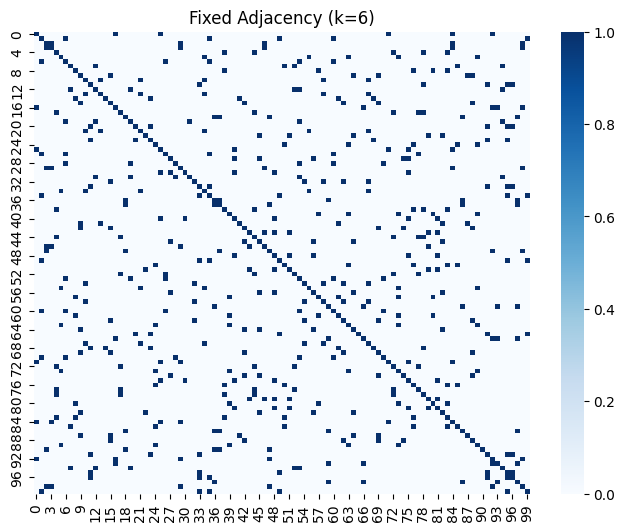

In [23]:

# 2. Extract coordinates from subsampled data
coords_subsampled = mydata_subsampled.obs[['x', 'y']].values

# 3. Plot fixed adjacency matrix
plot_fixed_adjacency(coords_subsampled)

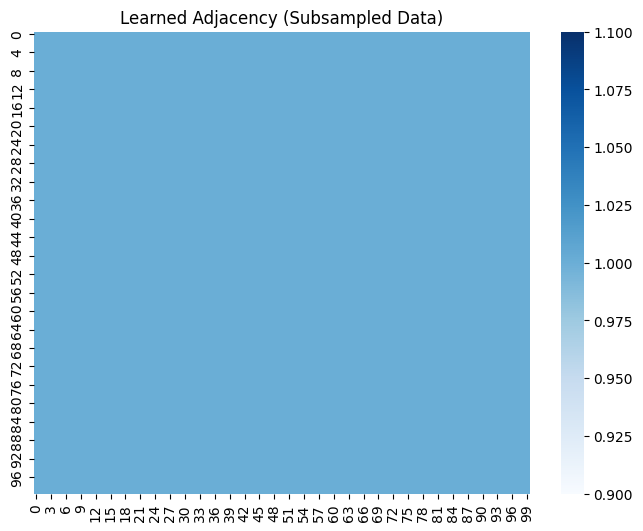

In [24]:
# Example: Plot learned adjacency
def plot_learned_adjacency(model, features):
    transformer_block = model.get_layer("transformer_gnn_block")
    adjacency_layer = transformer_block.adj_generator  
    adj = adjacency_layer(features).numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(adj, cmap="Blues")
    plt.title("Learned Adjacency (Subsampled Data)")
    plt.show()

plot_learned_adjacency(model, features_subsampled)  # Use subsampled features

/home/frankfurt/tf-env/lib/python3.10/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/frankfurt/tf-env/lib/python3.10/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


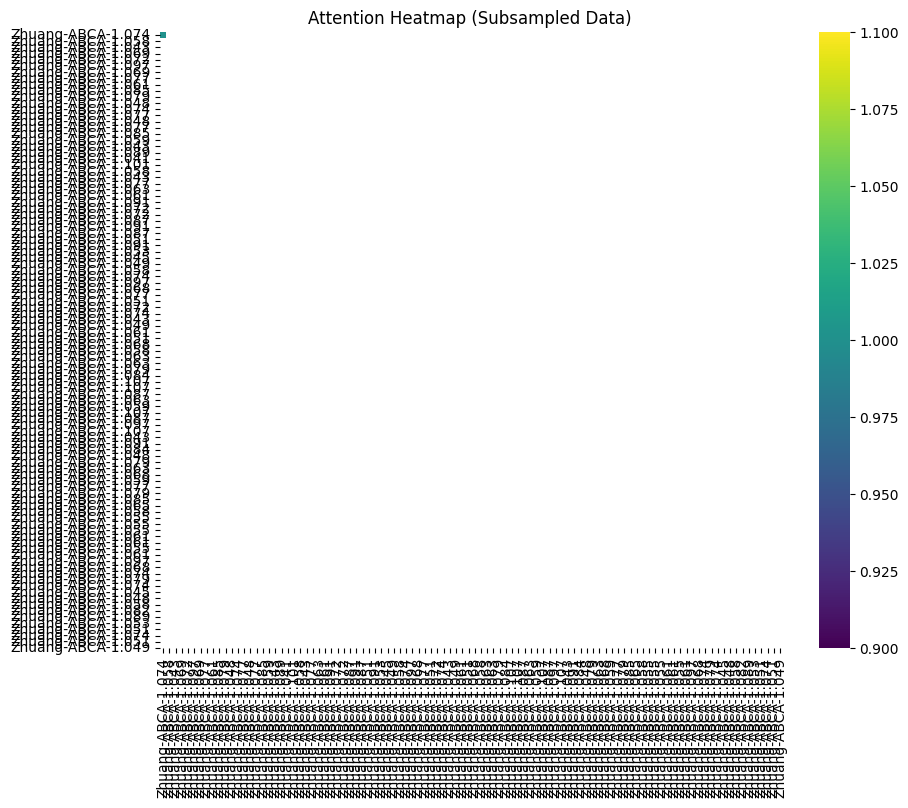

In [25]:
def plot_attention_heatmap(model, features, coords, region_labels):
    attention_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=model.outputs[2:]  # attn1, attn2
    )
    attn1, attn2 = attention_model.predict([features, coords], verbose=0)
    attn_avg = np.mean(attn1[0], axis=0)  # Avg across heads
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attn_avg,
        xticklabels=region_labels,
        yticklabels=region_labels,
        cmap="viridis"
    )
    plt.title("Attention Heatmap (Subsampled Data)")
    plt.show()

# Use subsampled data
plot_attention_heatmap(model, features_subsampled, coords_subsampled, region_labels_subsampled)

In [21]:


from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Example pseudo-code (adapt to your models)
stgnn_scores = cross_val_score(stgnn_model, mydata.X, mydata.obs['cluster'], cv=5)
spagcn_scores = cross_val_score(spagcn_model, mydata.X, mydata.obs['cluster'], cv=5)

# Then run the Wilcoxon test and Cohen's d on `stgnn_scores` vs `spagcn_scores`.




NameError: name 'stgnn_model' is not defined

In [9]:
# ===========================================
# 6. Post-Training Analysis (Fixed)
# ===========================================
# Create model to output attention weights
attention_model = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.outputs[2:]  # Get attention weights from both blocks
)

# Get sample attention weights
sample_idx = np.random.choice(len(cell_features), 50, replace=False)
attn1, attn2 = attention_model.predict(
    [cell_features[sample_idx], coords[sample_idx]],
    verbose=0
)

# Evaluation using validation set
test_acc = tf.keras.metrics.SparseCategoricalAccuracy()
test_top3 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)

for inputs, labels in val_ds:
    preds, _, _, _ = model(inputs, training=False)
    test_acc.update_state(labels, preds)
    test_top3.update_state(labels, preds)

print(f"\nFinal Test Accuracy: {test_acc.result().numpy():.4f}")
print(f"Top-3 Accuracy: {test_top3.result().numpy():.4f}")

/home/frankfurt/tf-env/lib/python3.10/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
I0000 00:00:1745952021.796360   44154 service.cc:152] XLA service 0x76316c0030a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745952021.796374   44154 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-29 13:40:21.817324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745952021.875261   44154 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-29 13:40:22.776788: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:


Final Test Accuracy: 0.3587
Top-3 Accuracy: 0.6153
